# Phase 3: 模型验证 (Model Validation)

## 概述 Overview

本Notebook实现Phase 3的二分类建模与迁移学习验证。

**主要任务：**
1. **标签二值化**: 基于中位数将稳定性分为"稳定"vs"不稳定"
2. **交叉验证**: 5折分层CV，训练LR/RF/XGBoost三种模型
3. **特征重要性**: 分析最具预测性的分子特征
4. **迁移学习**: 评估模型在不同数据集间的泛化能力
5. **结果可视化**: 混淆矩阵、性能对比、迁移热力图

**模型配置：**
- Logistic Regression: L2正则化, balanced权重
- Random Forest: 100棵树, balanced权重
- XGBoost: GPU加速, max_depth=6, balanced权重

**输入**: 
- `data/processed/*.csv` - 带分钟标签的CSV  
- `outputs/features/*.npz` - RDKit特征矩阵  

**输出**: 
- `outputs/model_results/phase3_binary/cv_results/` - CV结果JSON  
- `outputs/model_results/phase3_binary/feature_importance/` - 特征重要性CSV  
- `outputs/model_results/phase3_binary/transfer_results/` - 迁移学习JSON  
- `outputs/figures/phase3/` - 可视化图表  

---

## 1. 环境检查与导入 Environment Setup

In [10]:
# 环境检查
import sys
from pathlib import Path

# 添加项目根目录到路径
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# 核心库导入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

# 机器学习
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from xgboost import XGBClassifier

# 检查GPU可用性
try:
    import torch
    gpu_available = torch.cuda.is_available()
    if gpu_available:
        print(f"✓ GPU可用: {torch.cuda.get_device_name(0)}")
    else:
        print("⚠ GPU不可用，将使用CPU训练")
except ImportError:
    gpu_available = False
    print("⚠ PyTorch未安装，将使用CPU训练")

# 设置显示选项
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ 所有库已成功导入")
print(f"✓ 项目根目录: {project_root}")

⚠ PyTorch未安装，将使用CPU训练
✓ 所有库已成功导入
✓ 项目根目录: d:\RA\feature_extraction


In [11]:

def convert_numpy_types(obj):
    """递归转换numpy类型为Python原生类型"""
    import numpy as np
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj


## 2. 参数配置区 Configuration

**⚙️ 根据您的需求修改以下参数**

In [12]:
# ============== 参数配置区 ==============

CONFIG = {
    # 输入输出路径
    'processed_dir': project_root / 'data' / 'processed',
    'features_dir': project_root / 'outputs' / 'features',
    'cv_results_dir': project_root / 'outputs' / 'model_results' / 'phase3_binary' / 'cv_results',
    'feature_importance_dir': project_root / 'outputs' / 'model_results' / 'phase3_binary' / 'feature_importance',
    'transfer_results_dir': project_root / 'outputs' / 'model_results' / 'phase3_binary' / 'transfer_results',
    'figures_dir': project_root / 'outputs' / 'figures' / 'phase3',
    
    # 模型选择（可选: 'lr', 'rf', 'xgb'）
    'models_to_train': ['lr', 'rf', 'xgb'],
    
    # 交叉验证参数
    'n_folds': 5,
    'random_state': 42,
    
    # XGBoost参数
    'use_gpu': gpu_available,
    'xgb_max_depth': 6,
    'xgb_learning_rate': 0.1,
    'xgb_n_estimators': 100,
    
    # Random Forest参数
    'rf_n_estimators': 100,
    'rf_n_jobs': -1,
    
    # Logistic Regression参数
    'lr_max_iter': 1000,
    
    # 可视化参数
    'dpi': 300,
    'format': 'png',
    'display_plots': True,
    'max_display_plots': 8,
}

# 创建输出目录
for key in ['cv_results_dir', 'feature_importance_dir', 'transfer_results_dir', 'figures_dir']:
    CONFIG[key].mkdir(parents=True, exist_ok=True)

print("配置参数:")
print(f"  模型: {CONFIG['models_to_train']}")
print(f"  交叉验证折数: {CONFIG['n_folds']}")
print(f"  GPU加速: {CONFIG['use_gpu']}")
print(f"  XGBoost参数: max_depth={CONFIG['xgb_max_depth']}, lr={CONFIG['xgb_learning_rate']}")

配置参数:
  模型: ['lr', 'rf', 'xgb']
  交叉验证折数: 5
  GPU加速: False
  XGBoost参数: max_depth=6, lr=0.1


## 3. 数据加载与二值化 Data Loading & Binarization

In [13]:
def load_and_binarize_dataset(npz_path: Path, csv_path: Path, target: str, is_monomer: bool = None):
    """
    加载数据并将标签二值化，同时可选择只保留monomer或非monomer样本
    (2025-12-15新增功能)
    
    Args:
        npz_path: NPZ特征文件
        csv_path: 处理后的CSV文件（包含分钟标签）
        target: 'SIF' or 'SGF'
        is_monomer: 如果为True，只保留monomer；False，只保留非monomer；None不筛选
    
    Returns:
        X, y_binary, median_threshold, feature_names
    """
    # 加载NPZ特征
    data = np.load(npz_path, allow_pickle=True)
    X = data['X']
    feature_names = data['feature_names']
    ids_npz = data['ids']
    
    # 加载CSV获取分钟标签
    df = pd.read_csv(csv_path)
    df['id'] = df['id'].astype(str)
    
    # ID匹配：这里是建立一个映射数值
    id_to_idx = {str(id_): idx for idx, id_ in enumerate(ids_npz)}
    valid_indices = [] # 确定当前任务用哪一行
    valid_labels = []
    
    label_col = f"{target}_minutes" # 根据任务目标获取分钟数目
    for _, row in df.iterrows():
        row_id = str(row['id'])
        if row_id in id_to_idx:
            #===================================过滤无效标签=========================================
            label= row[label_col]
            if label == -1 or pd.isna(label):# 判断标签有效（对应的任务就只能做对应的二值化）
                continue
            if is_monomer is not None and row['is_monomer'] != is_monomer:  # 判断是否满足monomer条件
                continue
            if row[f"{target}_minutes"]>700: #特殊情况处理，如果是SIF_minuters>700
                continue   
            #=======================================================================================
            # 符合条件则加入
            valid_indices.append(id_to_idx[row_id]) # 获取对应数据的索引/序号
            valid_labels.append(label)              # 获取label
    
    # 筛选有效样本
    X_valid = X[valid_indices]   # 根据序号直接获取到值，这里是numpy的基本用法之一，比如传入【3，7】那么得到的就是第三行和第七行的数值
    y_minutes = np.array(valid_labels)  # 获取y值

    
    
    # 设定阈值========================
    median =None
    if target=='SIF':
        median = 270
    elif target=='SGF':
        median =250#（经过纠正250更好点）
    
    # 根据阈值判断是否稳定捏
    y_binary = (y_minutes >= median).astype(int)  # 1=稳定, 0=不稳定
    
    print(f"  样本数: {len(X_valid)}")
    print(f"  中位数阈值（更新后阈值根据75%划分得出结果）: {median:.1f} 分钟")
    print(f"  稳定/不稳定: {np.sum(y_binary==1)}/{np.sum(y_binary==0)}")
    
    return X_valid, y_binary, median, feature_names


# 加载所有数据集
datasets_data = {}
npz_files = sorted(CONFIG['features_dir'].glob('*_processed.npz'))
# 选择加载数据的时候就指定monomer或非monomer样本
is_monomer = True # 仅加载monomer样本，设置为False则加载非monomer样本，None则不筛选

print(f"加载并二值化 {len(npz_files)} 个数据集:\n")
for npz_file in npz_files:
    dataset_name = npz_file.stem.replace('_processed', '')
    csv_file = CONFIG['processed_dir'] / f"{dataset_name}_processed.csv"
    
    print(f"{dataset_name}:")

    # 此处新增数据集加载功能（第四个参数）
    
    # SIF
    X_sif, y_sif, median_sif, feat_names = load_and_binarize_dataset(npz_file, csv_file, 'SIF',is_monomer)
    print(f"  SIF数据选择完成，只获得单体数据")
    
    # SGF
    X_sgf, y_sgf, median_sgf, _ = load_and_binarize_dataset(npz_file, csv_file, 'SGF',is_monomer)
    print(f"  SGF数据选择完成，只获取单体数据\n")
    
    datasets_data[dataset_name] = {
        'X_sif': X_sif,
        'y_sif': y_sif,
        'median_sif': median_sif,
        'X_sgf': X_sgf,
        'y_sgf': y_sgf,
        'median_sgf': median_sgf,
        'feature_names': feat_names,
    }

print(f"✓ 数据加载完成！共 {len(datasets_data)} 个数据集")

#=============对数据进行一些处理=========================
# 字典序
#print("查看数据集类型",type(datasets_data))   
# dict_keys(['sif_sgf_second', 'US20140294902A1', 'US9624268', 'US9809623B2', 'WO2017011820A2'])
#print("尝试输出数据查看情况",datasets_data.keys()) 
# 字典序
#print("尝试输出数据查看情况",type(datasets_data['sif_sgf_second'])) 
# dict_keys(['X_sif', 'y_sif', 'median_sif', 'X_sgf', 'y_sgf', 'median_sgf', 'feature_names'])
#print("尝试输出数据查看情况",datasets_data['sif_sgf_second'].keys()) 
# 字典序
#print("尝试输出数据查看情况",type(datasets_data['sif_sgf_second']['X_sif'])) # 数据类型为 <class 'numpy.ndarray'>
# dict_keys(['X_sif', 'y_sif', 'median_sif', 'X_sgf', 'y_sgf', 'median_sgf', 'feature_names'])

# 两种任务的计算结果
#print("X_sif",datasets_data['sif_sgf_second']['X_sif'].shape) 
#print("y_sif",datasets_data['sif_sgf_second']['y_sif'].shape) 
#print("median_sif",datasets_data['sif_sgf_second']['median_sif']) 
#print("X_sgf",datasets_data['sif_sgf_second']['X_sgf'].shape) 
#print("y_sgf",datasets_data['sif_sgf_second']['y_sgf'].shape) 
#print("median_sgf",datasets_data['sif_sgf_second']['median_sgf']) 

#=============上方为数据的处理区域=======================

加载并二值化 5 个数据集:

sif_sgf_second:
  样本数: 202
  中位数阈值（更新后阈值根据75%划分得出结果）: 270.0 分钟
  稳定/不稳定: 0/202
  SIF数据选择完成，只获得单体数据
  样本数: 202
  中位数阈值（更新后阈值根据75%划分得出结果）: 250.0 分钟
  稳定/不稳定: 0/202
  SGF数据选择完成，只获取单体数据

US20140294902A1:
  样本数: 5
  中位数阈值（更新后阈值根据75%划分得出结果）: 270.0 分钟
  稳定/不稳定: 3/2
  SIF数据选择完成，只获得单体数据
  样本数: 0
  中位数阈值（更新后阈值根据75%划分得出结果）: 250.0 分钟
  稳定/不稳定: 0/0
  SGF数据选择完成，只获取单体数据

US9624268:
  样本数: 130
  中位数阈值（更新后阈值根据75%划分得出结果）: 270.0 分钟
  稳定/不稳定: 76/54
  SIF数据选择完成，只获得单体数据
  样本数: 90
  中位数阈值（更新后阈值根据75%划分得出结果）: 250.0 分钟
  稳定/不稳定: 52/38
  SGF数据选择完成，只获取单体数据

US9809623B2:
  样本数: 26
  中位数阈值（更新后阈值根据75%划分得出结果）: 270.0 分钟
  稳定/不稳定: 5/21
  SIF数据选择完成，只获得单体数据
  样本数: 5
  中位数阈值（更新后阈值根据75%划分得出结果）: 250.0 分钟
  稳定/不稳定: 5/0
  SGF数据选择完成，只获取单体数据

WO2017011820A2:
  样本数: 150
  中位数阈值（更新后阈值根据75%划分得出结果）: 270.0 分钟
  稳定/不稳定: 92/58
  SIF数据选择完成，只获得单体数据
  样本数: 105
  中位数阈值（更新后阈值根据75%划分得出结果）: 250.0 分钟
  稳定/不稳定: 65/40
  SGF数据选择完成，只获取单体数据

✓ 数据加载完成！共 5 个数据集


## 4. 交叉验证训练 Cross-Validation Training

In [14]:
def get_model(model_name: str, use_gpu: bool = False):
    """
    创建模型实例
    """
    if model_name == 'lr':
        return LogisticRegression(
            max_iter=CONFIG['lr_max_iter'],
            class_weight='balanced',
            random_state=CONFIG['random_state']
        )
    elif model_name == 'rf':
        return RandomForestClassifier(
            n_estimators=CONFIG['rf_n_estimators'],
            class_weight='balanced',
            n_jobs=CONFIG['rf_n_jobs'],
            random_state=CONFIG['random_state']
        )
    elif model_name == 'xgb':
        params = {
            'max_depth': CONFIG['xgb_max_depth'],
            'learning_rate': CONFIG['xgb_learning_rate'],
            'n_estimators': CONFIG['xgb_n_estimators'],
            'random_state': CONFIG['random_state'],
            'tree_method': 'hist',
        }
        if use_gpu:
            params['device'] = 'cuda:0'
        return XGBClassifier(**params)
    else:
        raise ValueError(f"Unknown model: {model_name}")

def cross_validate_model(X, y, model_name: str, dataset_name: str, target: str):
    """
    执行k折交叉验证
    
    Returns:
        dict: CV结果
    """
    # 自动调整fold数（小数据集）
    min_class_count = np.bincount(y).min()
    n_folds = min(CONFIG['n_folds'], min_class_count)
    if n_folds < CONFIG['n_folds']:
        print(f"    ⚠ 样本数较少，调整fold数为 {n_folds}")
    
    if n_folds < 2:
        print("    ⚠ 样本过少，无法进行分层交叉验证，跳过该任务")
        return None

    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=CONFIG['random_state'])
    
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # 训练模型
        model = get_model(model_name, CONFIG['use_gpu'])
        model.fit(X_train, y_train)
        
        # 预测
        y_pred = model.predict(X_test)
        # （修改后的probo）
        proba = model.predict_proba(X_test)
        if proba.shape[1] == 2:
            y_proba = proba[:, 1]
        else:
            y_proba = None  # 只有一个类别时，AUC 没有定义
        
        # 计算指标
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, average='binary', zero_division=0))
        metrics['recall'].append(recall_score(y_test, y_pred, average='binary', zero_division=0))
        metrics['f1'].append(f1_score(y_test, y_pred, average='binary', zero_division=0))
        
        # AUC（需要至少两个类别，新增一种情况与下面配合，就是只有一种类别）
        if y_proba is not None and len(np.unique(y_test)) > 1:
            metrics['auc'].append(roc_auc_score(y_test, y_proba))
        else:
            metrics['auc'].append(np.nan)
    
    # 汇总结果
    results = {
        'dataset': dataset_name,
        'target': target,
        'model': model_name,
        'n_folds': n_folds,
        'metrics': metrics,
        'mean_metrics': {k: np.nanmean(v) for k, v in metrics.items()},
        'std_metrics': {k: np.nanstd(v) for k, v in metrics.items()},
    }
    
    return results

# 执行：批量交叉验证
print("开始交叉验证训练...\n")
cv_results_all = []

for dataset_name, data in tqdm(datasets_data.items(), desc="数据集"):
    print(f"\n{dataset_name}:")
    
    for target in ['SIF', 'SGF']:
        X = data[f'X_{target.lower()}']
        y = data[f'y_{target.lower()}']
        
        if len(y) == 0:
            print(f"  {target}: 无有效样本，跳过")
            continue
        
        print(f"  {target}:")
        for model_name in CONFIG['models_to_train']:
            print(f"    {model_name.upper()}...", end=" ")

            #=====增加错误排除逻辑===========================
            try:
                results = cross_validate_model(X, y, model_name, dataset_name, target)
            except ValueError as e:
                #print(f"只有一种类别，跳过该任务 ✓ ，错误信息: {e}")
                print(f"只有一种类别，跳过该任务")
                continue
            
            

            # 增加跳出逻辑====================================
            if results is None:
                print("跳过 ✓")
                continue
            #===============================================

            cv_results_all.append(results)
            
            # 保存结果
            result_path = CONFIG['cv_results_dir'] / f"{dataset_name}_{target}_{model_name}_cv.json"
            with open(result_path, 'w') as f:
                json.dump(convert_numpy_types(results), f, indent=2)
            
            print(f"F1={results['mean_metrics']['f1']:.4f} ✓")

print(f"\n✓ 交叉验证完成！共 {len(cv_results_all)} 个实验")
print(f"  结果已保存到: {CONFIG['cv_results_dir'].relative_to(project_root)}")

开始交叉验证训练...



数据集:   0%|          | 0/5 [00:00<?, ?it/s]


sif_sgf_second:
  SIF:
    LR... 只有一种类别，跳过该任务
    RF... F1=0.0000 ✓
    XGB... 只有一种类别，跳过该任务
  SGF:
    LR... 只有一种类别，跳过该任务
    RF... F1=0.0000 ✓
    XGB... 只有一种类别，跳过该任务

US20140294902A1:
  SIF:
    LR...     ⚠ 样本数较少，调整fold数为 2
F1=1.0000 ✓
    RF...     ⚠ 样本数较少，调整fold数为 2
F1=1.0000 ✓
    XGB...     ⚠ 样本数较少，调整fold数为 2
F1=0.3333 ✓
  SGF: 无有效样本，跳过

US9624268:
  SIF:
    LR... F1=0.6711 ✓
    RF... F1=0.7587 ✓
    XGB... F1=0.7235 ✓
  SGF:
    LR... F1=0.7500 ✓
    RF... F1=0.7439 ✓
    XGB... F1=0.6940 ✓

US9809623B2:
  SIF:
    LR... F1=0.1000 ✓
    RF... F1=0.0000 ✓
    XGB... F1=0.2000 ✓
  SGF:
    LR...     ⚠ 样本数较少，调整fold数为 0
    ⚠ 样本过少，无法进行分层交叉验证，跳过该任务
跳过 ✓
    RF...     ⚠ 样本数较少，调整fold数为 0
    ⚠ 样本过少，无法进行分层交叉验证，跳过该任务
跳过 ✓
    XGB...     ⚠ 样本数较少，调整fold数为 0
    ⚠ 样本过少，无法进行分层交叉验证，跳过该任务
跳过 ✓

WO2017011820A2:
  SIF:
    LR... F1=0.8290 ✓
    RF... F1=0.7890 ✓
    XGB... F1=0.8211 ✓
  SGF:
    LR... F1=0.8192 ✓
    RF... F1=0.8614 ✓
    XGB... F1=0.8053 ✓

✓ 交叉验证完成！共 20 个实验
  结果已保存到: output

## 5. 特征重要性分析 Feature Importance

In [15]:
# 提取RF和XGBoost的特征重要性（只对一个数据集示例）
print("提取特征重要性...\n")

importance_count = 0
for dataset_name, data in datasets_data.items():
    for target in ['SIF', 'SGF']:
        X = data[f'X_{target.lower()}']
        y = data[f'y_{target.lower()}']
        feature_names = data['feature_names']
        
        if len(y) == 0:
            continue
        
        # RF特征重要性
        rf = get_model('rf', False)
        rf.fit(X, y)
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        imp_path = CONFIG['feature_importance_dir'] / f"{dataset_name}_{target}_rf_importance.csv"
        importance_df.to_csv(imp_path, index=False)
        importance_count += 1
        
        # XGBoost特征重要性
        xgb = get_model('xgb', CONFIG['use_gpu'])

        # 排除特殊情况
        try:
            xgb.fit(X, y)
        except Exception as e:
            print(f"跳过XGBoost特征重要性提取，错误信息: {e}")
            continue
        
        
        importance_df_xgb = pd.DataFrame({
            'feature': feature_names,
            'importance': xgb.feature_importances_
        }).sort_values('importance', ascending=False)
        
        imp_path_xgb = CONFIG['feature_importance_dir'] / f"{dataset_name}_{target}_xgb_importance.csv"
        importance_df_xgb.to_csv(imp_path_xgb, index=False)
        importance_count += 1

print(f"✓ 特征重要性提取完成！共 {importance_count} 个文件")
print(f"  结果已保存到: {CONFIG['feature_importance_dir'].relative_to(project_root)}")

提取特征重要性...

跳过XGBoost特征重要性提取，错误信息: [20:45:01] C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:119: Check failed: is_valid: base_score must be in (0,1) for the logistic loss.
跳过XGBoost特征重要性提取，错误信息: [20:45:01] C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:119: Check failed: is_valid: base_score must be in (0,1) for the logistic loss.
跳过XGBoost特征重要性提取，错误信息: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]
✓ 特征重要性提取完成！共 15 个文件
  结果已保存到: outputs\model_results\phase3_binary\feature_importance


## 6. 迁移学习 Transfer Learning

评估模型在不同数据集间的泛化能力（Train on A, Test on B）

In [16]:
def transfer_learning_test(X_train, y_train, X_test, y_test, model_name: str, use_gpu: bool = False):
    """
    迁移学习测试
    """
    model = get_model(model_name, use_gpu)

            # 排除特殊情况
    try:
        xgb.fit(X, y)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    except Exception as e:
        print(f"由于标签问题无法成功进行迁移学习测试，跳过该任务")
        return None
        
    
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='binary', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='binary', zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
    }
    
    return metrics

# 执行：双向迁移学习
print("开始迁移学习测试...\n")
transfer_results_all = []
dataset_names = list(datasets_data.keys())

for i, train_dataset in enumerate(dataset_names):
    for j, test_dataset in enumerate(dataset_names):
        if i == j:  # 跳过自己
            continue
        
        print(f"{train_dataset} → {test_dataset}:")
        
        for target in ['SIF', 'SGF']:
            X_train = datasets_data[train_dataset][f'X_{target.lower()}']
            y_train = datasets_data[train_dataset][f'y_{target.lower()}']
            X_test = datasets_data[test_dataset][f'X_{target.lower()}']
            y_test = datasets_data[test_dataset][f'y_{target.lower()}']
            
            if len(y_train) == 0 or len(y_test) == 0:
                print(f"  {target}: 样本不足，跳过")
                continue
            
            print(f"  {target}:", end=" ")
            for model_name in CONFIG['models_to_train']:
                metrics = transfer_learning_test(X_train, y_train, X_test, y_test, model_name, CONFIG['use_gpu'])
                
                result = {
                    'train_dataset': train_dataset,
                    'test_dataset': test_dataset,
                    'target': target,
                    'model': model_name,
                    'metrics': metrics,
                }
                transfer_results_all.append(result)
                
                # 保存结果
                result_path = CONFIG['transfer_results_dir'] / f"{train_dataset}_to_{test_dataset}_{target}_{model_name}.json"
                with open(result_path, 'w') as f:
                    json.dump(result, f, indent=2)
                
                if metrics is None:
                    print(f"{model_name.upper()}(跳过) ", end=" ")
                else:
                    print(f"{model_name.upper()}(F1={metrics['f1']:.3f})", end=" ")
            print()

print(f"\n✓ 迁移学习完成！共 {len(transfer_results_all)} 个实验")
print(f"  结果已保存到: {CONFIG['transfer_results_dir'].relative_to(project_root)}")

开始迁移学习测试...

sif_sgf_second → US20140294902A1:
  SIF: 由于标签问题无法成功进行迁移学习测试，跳过该任务
LR(跳过)  RF(F1=0.000) 由于标签问题无法成功进行迁移学习测试，跳过该任务
XGB(跳过)  
  SGF: 样本不足，跳过
sif_sgf_second → US9624268:
  SIF: 由于标签问题无法成功进行迁移学习测试，跳过该任务
LR(跳过)  RF(F1=0.000) 由于标签问题无法成功进行迁移学习测试，跳过该任务
XGB(跳过)  
  SGF: 由于标签问题无法成功进行迁移学习测试，跳过该任务
LR(跳过)  RF(F1=0.000) 由于标签问题无法成功进行迁移学习测试，跳过该任务
XGB(跳过)  
sif_sgf_second → US9809623B2:
  SIF: 由于标签问题无法成功进行迁移学习测试，跳过该任务
LR(跳过)  RF(F1=0.000) 由于标签问题无法成功进行迁移学习测试，跳过该任务
XGB(跳过)  
  SGF: 由于标签问题无法成功进行迁移学习测试，跳过该任务
LR(跳过)  RF(F1=0.000) 由于标签问题无法成功进行迁移学习测试，跳过该任务
XGB(跳过)  
sif_sgf_second → WO2017011820A2:
  SIF: 由于标签问题无法成功进行迁移学习测试，跳过该任务
LR(跳过)  RF(F1=0.000) 由于标签问题无法成功进行迁移学习测试，跳过该任务
XGB(跳过)  
  SGF: 由于标签问题无法成功进行迁移学习测试，跳过该任务
LR(跳过)  RF(F1=0.000) 由于标签问题无法成功进行迁移学习测试，跳过该任务
XGB(跳过)  
US20140294902A1 → sif_sgf_second:
  SIF: LR(F1=0.000) RF(F1=0.000) XGB(F1=0.000) 
  SGF: 样本不足，跳过
US20140294902A1 → US9624268:
  SIF: LR(F1=0.738) RF(F1=0.738) XGB(F1=0.738) 
  SGF: 样本不足，跳过
US20140294902A1 → US9809623B2:
  SIF: LR(F

## 7. 结果可视化 Visualization


生成迁移学习热力图...
✓ 已保存: transfer_heatmap_SIF_lr.png


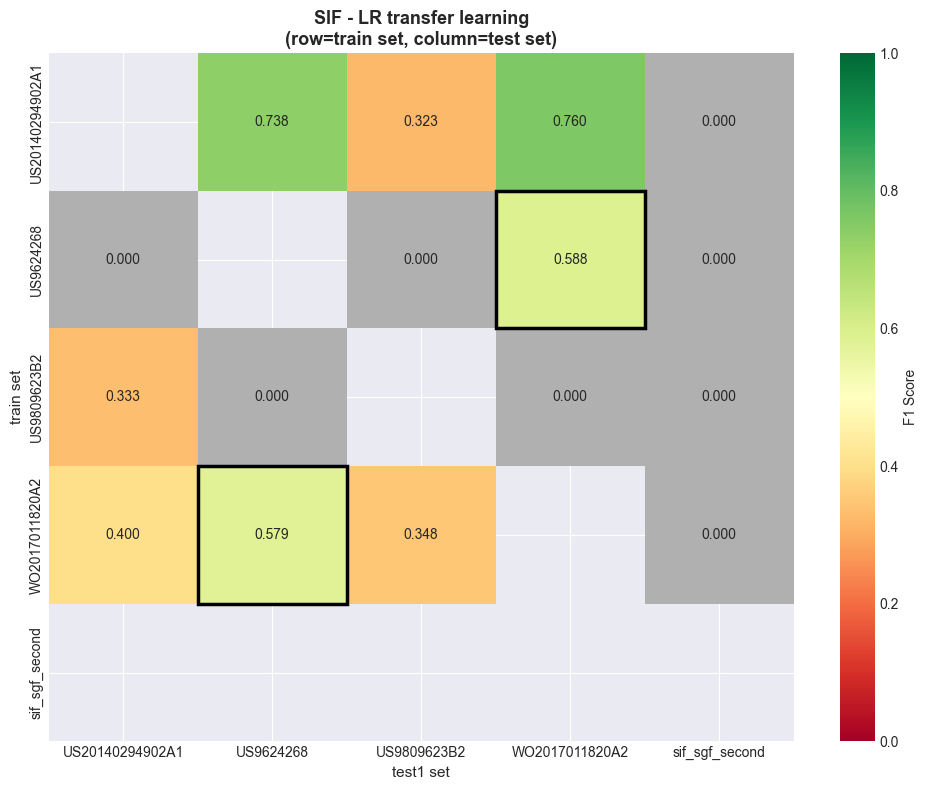

✓ 已保存: transfer_heatmap_SIF_rf.png


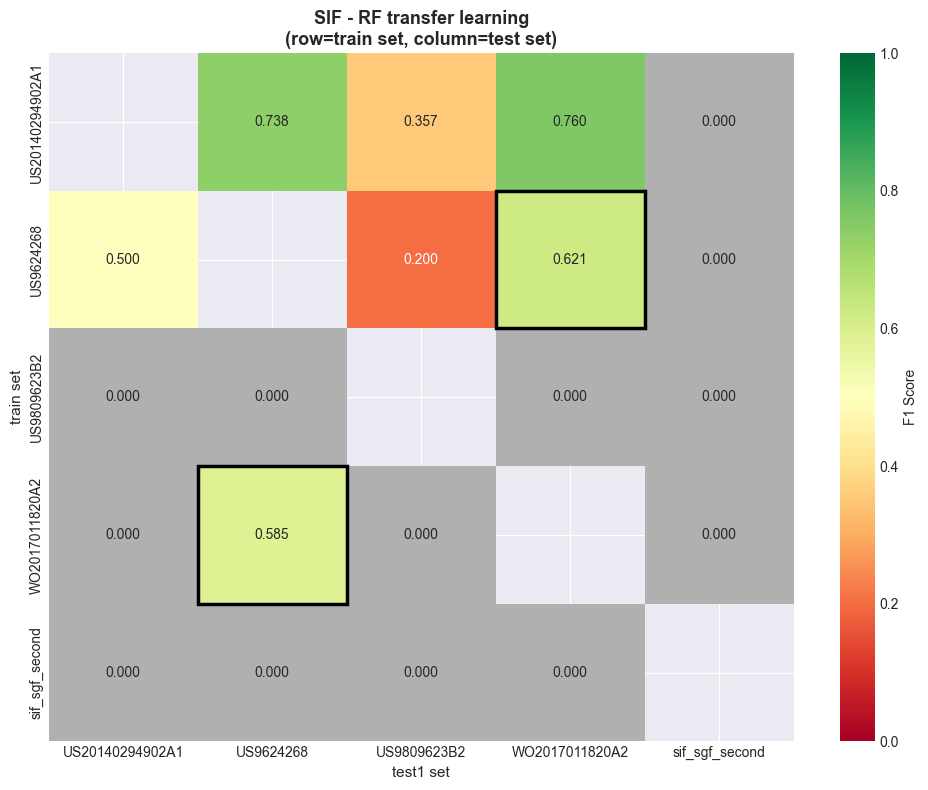

✓ 已保存: transfer_heatmap_SIF_xgb.png


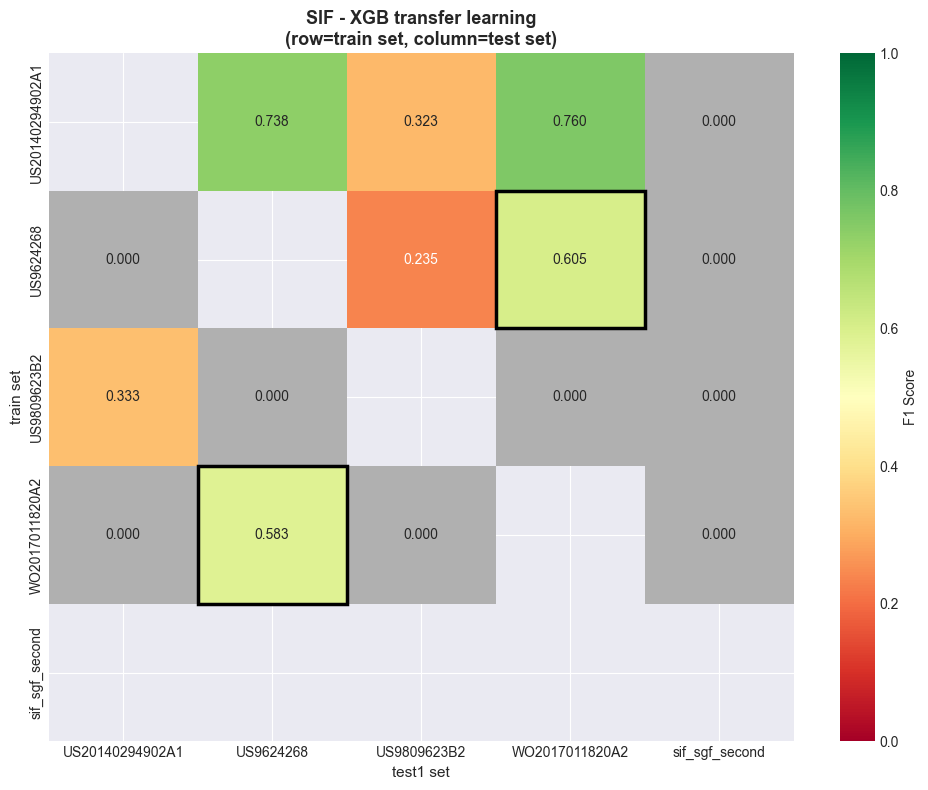

✓ 已保存: transfer_heatmap_SGF_lr.png


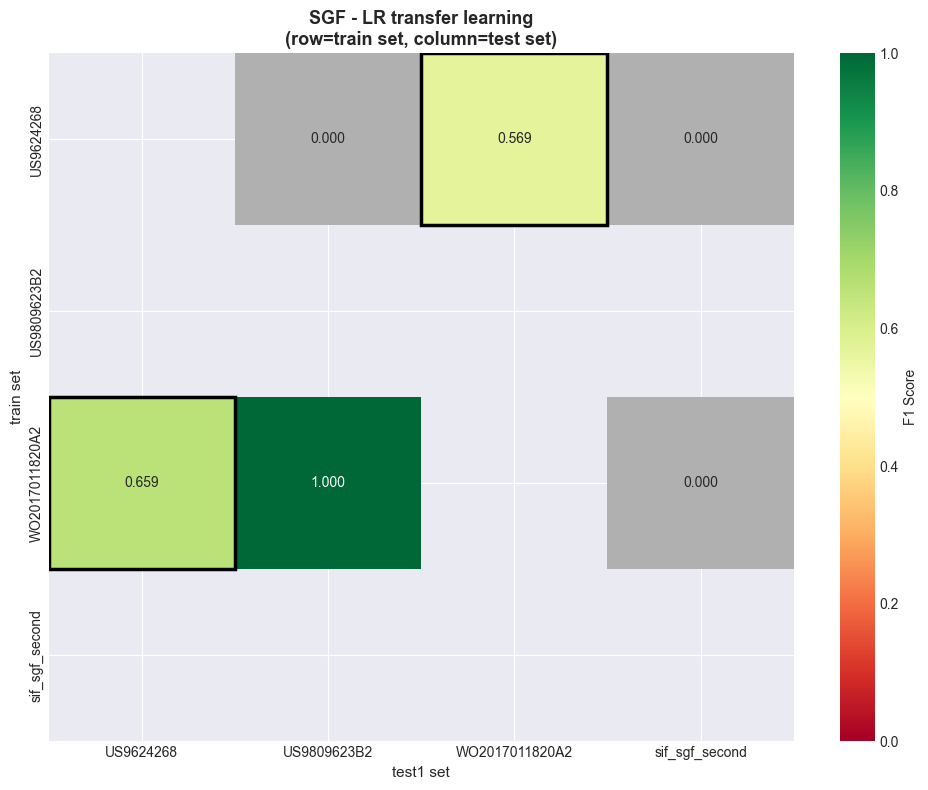

✓ 已保存: transfer_heatmap_SGF_rf.png


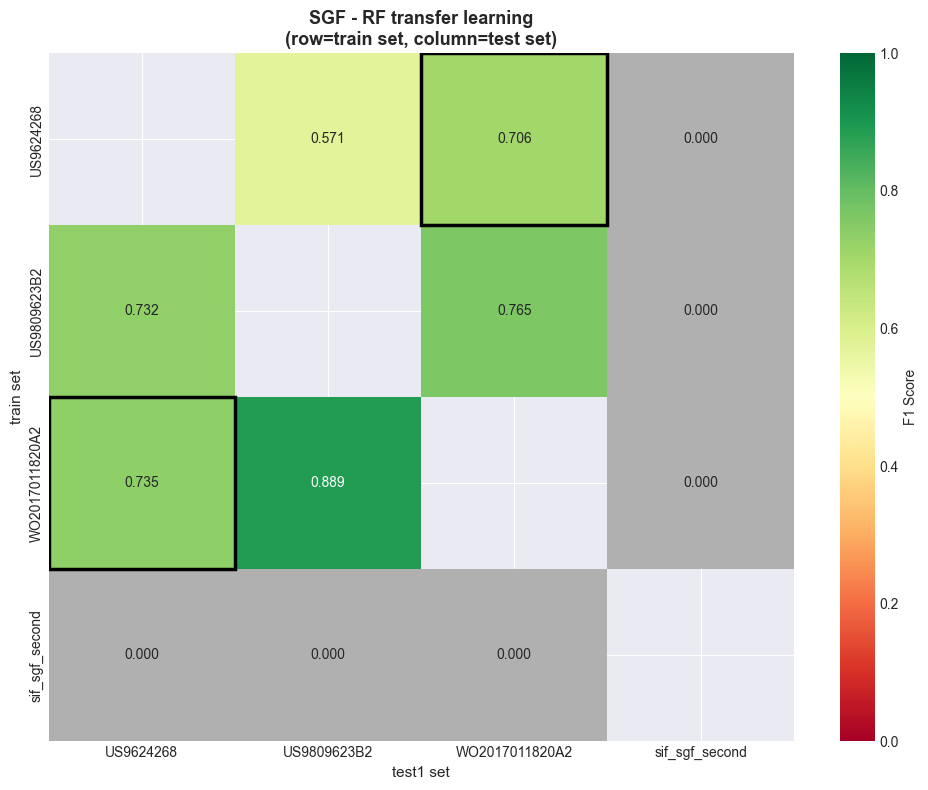

✓ 已保存: transfer_heatmap_SGF_xgb.png


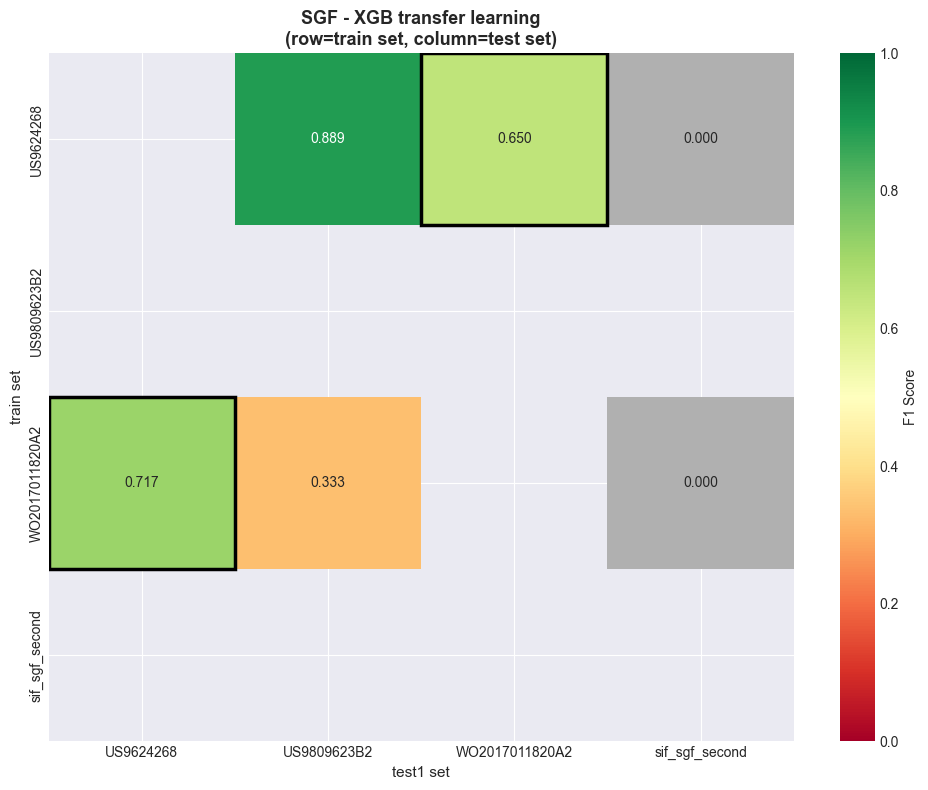

In [17]:
# 7.2 迁移学习热力图（支持 0 值灰色 + 特定数据集加粗框）
print("\n生成迁移学习热力图...")

highlight_pairs = [
    ('US9624268', 'WO2017011820A2'),
    ('WO2017011820A2', 'US9624268')
]

for target in ['SIF', 'SGF']:
    for model in ['lr', 'rf', 'xgb']:
        # 构建F1 Score矩阵
        transfer_df = pd.DataFrame([{
            'train': r['train_dataset'],
            'test': r['test_dataset'],
            'f1': r['metrics']['f1'] if r['metrics'] is not None else np.nan
        } for r in transfer_results_all
          if r['target'] == target and r['model'] == model])

        if len(transfer_df) == 0:
            continue

        heatmap_data = transfer_df.pivot(
            index='train',
            columns='test',
            values='f1'
        )

        # ========= 关键 mask =========
        nan_mask = heatmap_data.isna()     # NaN → 空白
        zero_mask = heatmap_data == 0      # 0 → 灰色

        fig, ax = plt.subplots(figsize=(10, 8))

        # ========= 第一层：正常 F1 =========
        sns.heatmap(
            heatmap_data,
            mask=nan_mask | zero_mask,
            annot=True,
            fmt='.3f',
            cmap='RdYlGn',
            vmin=0,
            vmax=1,
            ax=ax,
            cbar_kws={'label': 'F1 Score'}
        )

        # ========= 第二层：F1 == 0 → 特殊灰色 =========
        sns.heatmap(
            heatmap_data,
            mask=~zero_mask,
            annot=True,
            fmt='.3f',
            cmap=sns.color_palette(['#B0B0B0']),  # 特殊灰
            cbar=False,
            ax=ax
        )

        # ========= 加粗框：指定数据集双向迁移 =========
        for train_ds, test_ds in highlight_pairs:
            if train_ds in heatmap_data.index and test_ds in heatmap_data.columns:
                y = heatmap_data.index.get_loc(train_ds)
                x = heatmap_data.columns.get_loc(test_ds)

                rect = plt.Rectangle(
                    (x, y),
                    1, 1,
                    fill=False,
                    edgecolor='black',
                    linewidth=2.5
                )
                ax.add_patch(rect)

        # ========= 图形设置 =========
        ax.set_title(
            f'{target} - {model.upper()} transfer learning\n'
            f'(row=train set, column=test set)',
            fontsize=13,
            fontweight='bold'
        )
        ax.set_xlabel('test1 set', fontsize=11)
        ax.set_ylabel('train set', fontsize=11)

        plt.tight_layout()

        heatmap_path = (
            CONFIG['figures_dir']
            / f'transfer_heatmap_{target}_{model}.png'
        )
        plt.savefig(
            heatmap_path,
            dpi=CONFIG['dpi'],
            bbox_inches='tight'
        )
        print(f"✓ 已保存: {heatmap_path.name}")

        if CONFIG['display_plots']:
            plt.show()
        else:
            plt.close()


## 8. 结果总结 Summary

In [18]:
print("="*70)
print("Phase 3: 模型验证 - 执行完毕")
print("="*70)

print("\n📁 生成的文件:")
print(f"\n  1. CV结果 ({len(list(CONFIG['cv_results_dir'].glob('*.json')))} 个JSON):")
print(f"     {CONFIG['cv_results_dir'].relative_to(project_root)}")

print(f"\n  2. 特征重要性 ({len(list(CONFIG['feature_importance_dir'].glob('*.csv')))} 个CSV):")
print(f"     {CONFIG['feature_importance_dir'].relative_to(project_root)}")

print(f"\n  3. 迁移学习结果 ({len(list(CONFIG['transfer_results_dir'].glob('*.json')))} 个JSON):")
print(f"     {CONFIG['transfer_results_dir'].relative_to(project_root)}")

print(f"\n  4. 可视化图表 ({len(list(CONFIG['figures_dir'].glob('*.png')))} 个PNG):")
for f in sorted(CONFIG['figures_dir'].glob('*.png')):
    print(f"     - {f.name}")

# 找出最佳模型
best_cv = max(cv_results_all, key=lambda x: x['mean_metrics']['f1'])
print("\n🏆 最佳CV模型:")
print(f"  数据集: {best_cv['dataset']}")
print(f"  目标: {best_cv['target']}")
print(f"  模型: {best_cv['model'].upper()}")
print(f"  F1 Score: {best_cv['mean_metrics']['f1']:.4f} ± {best_cv['std_metrics']['f1']:.4f}")
print(f"  Accuracy: {best_cv['mean_metrics']['accuracy']:.4f} ± {best_cv['std_metrics']['accuracy']:.4f}")

best_transfer = max(transfer_results_all, key=lambda x: x['metrics']['f1'] if x['metrics'] is not None else -1)
print("\n🌐 最佳迁移学习模型:")
print(f"  训练集: {best_transfer['train_dataset']}")
print(f"  测试集: {best_transfer['test_dataset']}")
print(f"  目标: {best_transfer['target']}")
print(f"  模型: {best_transfer['model'].upper()}")
print(f"  F1 Score: {best_transfer['metrics']['f1']:.4f}")

print("\n📊 总体统计:")
print(f"  交叉验证实验: {len(cv_results_all)}")
print(f"  迁移学习实验: {len(transfer_results_all)}")
print(f"  特征重要性分析: {importance_count}")

print("\n✅ Phase 3 完成！所有结果已保存")
print("="*70)

Phase 3: 模型验证 - 执行完毕

📁 生成的文件:

  1. CV结果 (28 个JSON):
     outputs\model_results\phase3_binary\cv_results

  2. 特征重要性 (19 个CSV):
     outputs\model_results\phase3_binary\feature_importance

  3. 迁移学习结果 (97 个JSON):
     outputs\model_results\phase3_binary\transfer_results

  4. 可视化图表 (15 个PNG):
     - cv_f1_heatmap_SGF.png
     - cv_f1_heatmap_SIF.png
     - cv_performance_comparison.png
     - transfer_f1_heatmap_SGF_lr.png
     - transfer_f1_heatmap_SGF_rf.png
     - transfer_f1_heatmap_SGF_xgb.png
     - transfer_f1_heatmap_SIF_lr.png
     - transfer_f1_heatmap_SIF_rf.png
     - transfer_f1_heatmap_SIF_xgb.png
     - transfer_heatmap_SGF_lr.png
     - transfer_heatmap_SGF_rf.png
     - transfer_heatmap_SGF_xgb.png
     - transfer_heatmap_SIF_lr.png
     - transfer_heatmap_SIF_rf.png
     - transfer_heatmap_SIF_xgb.png

🏆 最佳CV模型:
  数据集: US20140294902A1
  目标: SIF
  模型: LR
  F1 Score: 1.0000 ± 0.0000
  Accuracy: 1.0000 ± 0.0000

🌐 最佳迁移学习模型:
  训练集: WO2017011820A2
  测试集: US9809623B2
  目标: